**Mapping closure for $f_B$ in 1D using a Monte-Carlo Implementation**

This notebook introduces the mapping closure developed by (Chen, H. 1989, Pope, S.B. 1991) and discusses how it can be applied to the problem of turbulent scalar mixing. In contrast to these works which consider a one-point pdf, usually in the context of homogeneous isotropic turbulence, we consider the *global pdf* describing the contents of an arbitrary control volume.


**Content**

We first import all the packages we need to run this example

In [12]:
import numpy as np
import matplotlib.pyplot as plt

**Evolution equation for the PDF**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial F}{\partial t} = -\mathbb{E}_Y[ \Gamma \nabla^2 Y ] \frac{\partial F}{\partial y},
\end{equation}

and

\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial y} \left( \mathbb{E}_Y[ \Gamma \nabla^2 Y ] f \right).
\end{equation}

As $f(y,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the mapping closure developed by [Pope et al. 1991](https://link.springer.com/article/10.1007/BF00271466) to estimate a closure for the molecular mixing terms.

The idea behind this closure relies on Gaussian random fields. What makes these "random" fields particularly useful is:
- They are completely defined by their mean and covariance: 
\begin{equation}
    \mu = \mathbb{E}[\theta(\mathbf{z})], \quad \rho(r) = \mathbb{E}[\theta(\mathbf{z})\theta(\mathbf{z} + \mathbf{e}r)] - \mu^2,
\end{equation}
- Allow the calculate explicity the conditional expectation
\begin{equation}
lim_{r \to 0} \frac{\partial^2 \rho(r)}{\partial r^2} = \left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \right\rangle,
\end{equation}

and the fact that mutliple different field can have the same global PDF. Below we show and example of a Gaussian random field $\theta(\mathbf{z})$ with a $-5/3$ power-spectrum.


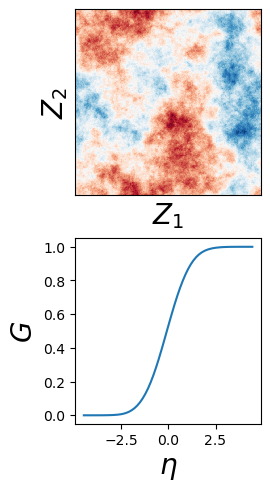

In [13]:
# Function to generate a Gaussian Random field
def gaussian_random_field(power_spectrum, shape = (128, 128), stat_real=False):
  """
  Generate a scale free Gaussian Random field Y(X) using the
  fast Fourier transform (FFT) and the power spectral density P(k)

  Y(x) = IFFT( P(k) * FFT(W(X)) )(X)

  where W(X) is a Gaussian white noise random field.

  Parameters
  ----------
  power_spectrum : (callable)
    Power spectral density P(k)
  shape : (int, int) G
    Grid size of the field generated

  Returns
  -------
  Y(X) : (array)
    Gaussian random field
  """
  if not callable(power_spectrum):
    raise Exception("`power_spectrum` should be callable")

  def statistic(shape):
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=shape)
    b = np.random.normal(loc=0, scale=1, size=shape)
    return a + 1j * b

  # Compute the k grid
  fftfreq = np.fft.fftfreq
  all_k = [fftfreq(s, d=1/s) for s in shape]
  kgrid = np.meshgrid(*all_k, indexing="ij")  # Reutrns kX, kY
  knorm = np.sqrt(np.sum(np.power(kgrid, 2), axis=0))  # Computes ||k|| = \sqrt{kX^2 + kY^2}

  # (1) Compute the Fourier transform of Gaussian White noise W(X)
  if stat_real:
    W = statistic(shape)
    # Compute the FFT of the field
    FW = np.fft.fftn(W)
  else:
    # Draw a random sample in Fourier space
    fourier_shape = knorm.shape
    FW = statistic(fourier_shape)

  # (2) Multiply by P(k)^{1/2}
  power_k = np.zeros_like(knorm)
  mask = knorm > 0
  power_k[mask] = np.sqrt(power_spectrum(knorm[mask]))
  FW *= power_k

  # (3) Take its IFFT
  return  np.real(np.fft.ifftn(FW))

# Create an example
n_pts = 512
power_spectrum = lambda k: k**-3
shape = (n_pts, n_pts)

Z_1 = np.linspace(-np.pi,np.pi,num=n_pts)
Z_2 = np.linspace(-np.pi,np.pi,num=n_pts)
Ys = gaussian_random_field(power_spectrum, shape) # Ys for Y surrogate

# Plot Z(z) and F_Z
fig, (ax0,ax1) = plt.subplots(nrows=2, ncols=1, layout="constrained")

# plot Ys(Z) as a field
cmap = plt.get_cmap('RdBu')
ax0.pcolormesh(Z_1, Z_2, Ys, cmap=cmap)
ax0.set_xlabel(r'$Z_1$', fontsize=20)
ax0.set_ylabel(r'$Z_2$', fontsize=20)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_box_aspect(1)

# plot its cdf by averaging over realisations
Ys = []
for i in range(64):
  Ys_i = gaussian_random_field(power_spectrum, shape)
  Ys.append(Ys_i.flatten())
Ys = np.concatenate(Ys).flatten()

sigma = np.std(Ys)
mean = np.mean(Ys)

Ys = (Ys - mean)/sigma

f,s= np.histogram(Ys, bins=64, density=True)
s  = 0.5*(s[1:] + s[:-1]); ds = s[1] - s[0]
F = np.cumsum(f)*ds
ax1.plot(s, F)
ax1.set_xlabel(r'$\eta$', fontsize=20)
ax1.set_ylabel(r'$G$', fontsize=20)
ax1.set_box_aspect(1)

plt.show()

**Mapping Closure**

Based on the properties of the Gaussian random field the idea is therefore to find a mapping 
\begin{equation}
\tilde{Y}(\mathbf{x},t) = \mathscr{Y}(\theta(\mathbf{x} J(t)),t),
\end{equation}
such that we can express the CDF $F$ in terms of the cumulative Gaussian $G$ 
\begin{equation}
F(\mathscr{Y}(\eta,t),t) = G(\eta).
\end{equation}

Differentiating the last equation we obtain
\begin{equation}
\frac{ \partial F}{\partial t} = -\frac{ \partial \mathscr{Y}}{\partial t} \frac{ \partial F}{\partial y}.
\end{equation}
which can then be expressed as
\begin{equation}
\frac{\partial \mathscr{Y}}{\partial t} = \mathbb{E}_Y[ \Gamma \nabla^2 Y ] = \Gamma \underbrace{\frac{J^2(t)}{\lambda_{\theta}^2}}_{= 1/\tau} \left( \frac{\partial^2 \mathscr{Y} }{\partial \eta^2} - \eta \frac{\partial \mathscr{Y} }{\partial \eta} \right).
\end{equation}

**Particle Implementation**

Although we can solve this equation as a PDE on a grid using a standard method such as finite-difference it is also possible to use a particle method. Let $g(\eta)$ be the PDF of the random variable $\theta_t$ be generated an Ornstein-Uhlenbeck process:

\begin{equation}
  d \theta_{t} = -\frac{\theta_{t}}{T} d t +\left(\frac{2}{T} \right)^{1/2} d W_{t},
\end{equation}

and $Y_{t}=\mathscr{Y}(\theta_t,t)$, if follows from Ito's lemma implies that

\begin{equation}
  d Y_{t} = \frac{\partial \mathscr{Y}_{t} }{\partial t} dt + \frac{1}{T} \left( -\theta_{t} \frac{\partial \mathscr{Y}_{t}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^{2}} \right) dt + \frac{\partial \mathscr{Y}_{t}}{\partial \eta} \left( \frac{2}{T} \right)^{1/2} d W_{t},
\end{equation}

where $\eta$ is the sample-space (or dummy) variable corresponding to the random variable $\theta_t$. Substitution of \eqref{eq:dYdt} then gives 

\begin{equation} 
 d Y_{t} = \left( \frac{1}{\tau} + \frac{1}{T} \right) \left( -\theta_{t} \frac{\partial \mathscr{Y}_{t}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^{2}} \right) dt + \frac{\partial \mathscr{Y}_{t}}{\partial \eta} \left( \frac{2}{T} \right)^{1/2} d W_{t}.
\end{equation}

As the mapping $\mathscr{Y}_t$ is constrained by the relation between the CDFs it follows that 

\begin{equation}
\frac{\partial \mathscr{Y}_t}{\partial \eta} = \frac{g(\eta)}{f_{Y}(\mathscr{Y}(\eta,t),t)},
\end{equation}

from which it is clear that the system of equations depend on the global PDF at each time-step and thus corresponds to a McKean-Vlasov equation.



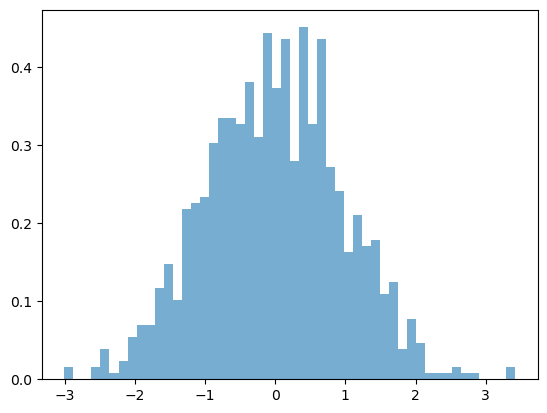

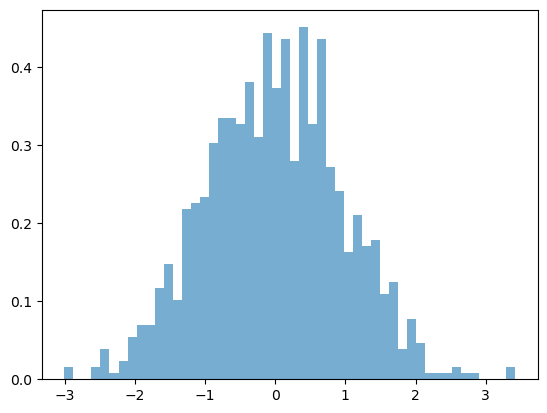

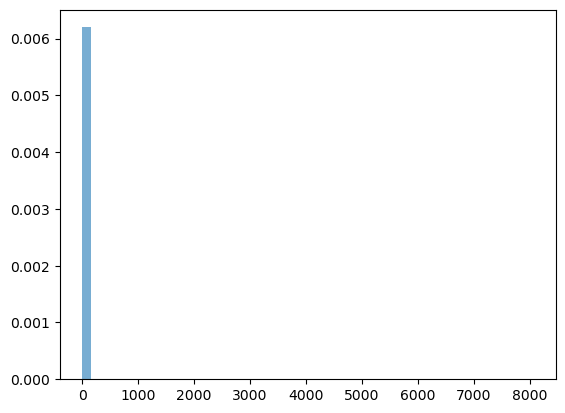

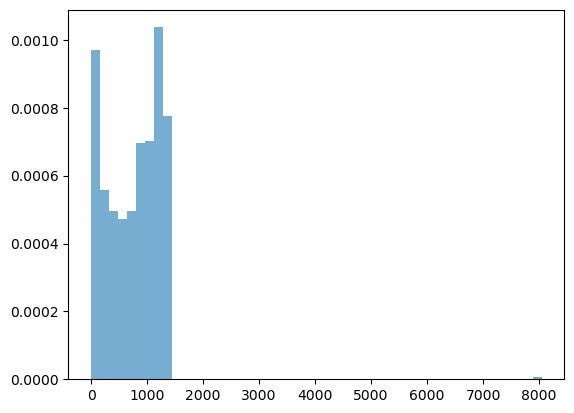

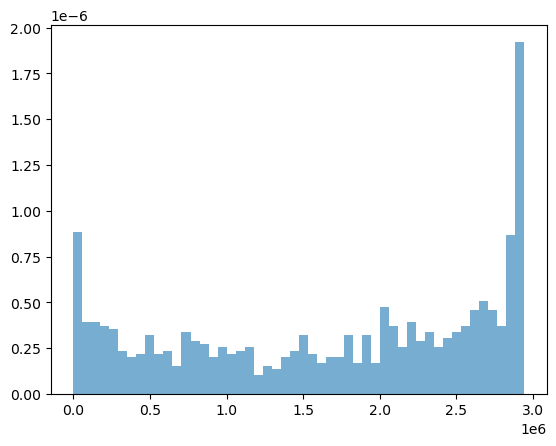

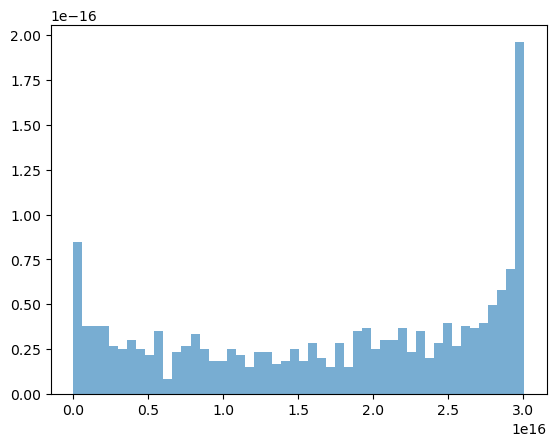

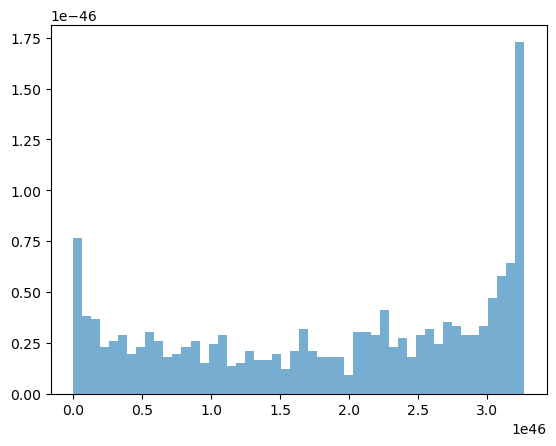

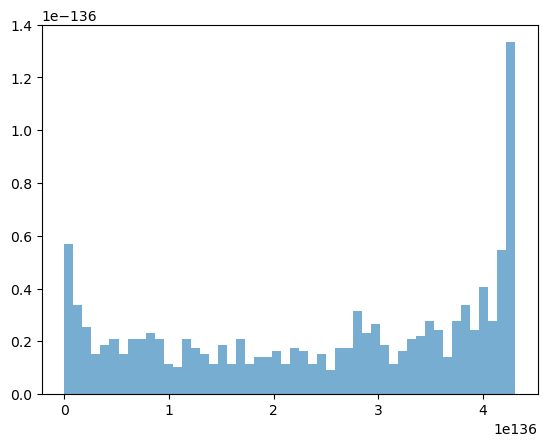

/tmp/ipykernel_4338/406165249.py:42: RuntimeWarning: overflow encountered in multiply
  dY2dη2 = lambda η: -(1/f(η))*( η*g(η) + (g(η)/f(η))**2 )


ValueError: supplied range of [inf, inf] is not finite

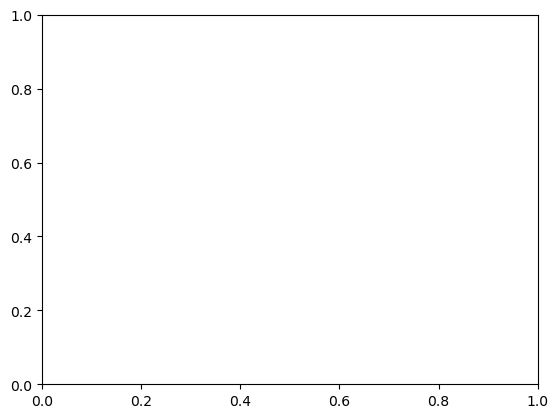

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy.stats import gaussian_kde, norm

# Parameters
num_particles = 10**3  # Number of Monte Carlo samples
num_steps = 100      # Time steps
dt = 0.001          # Time step size
T  = 1
τ  = 1

Y_min = -2
Y_max =  2

# Brownian increments
dW_t = np.sqrt(dt) * norm.rvs(loc=0, scale=1, size=(num_particles, num_steps, 2))  

# Container
θ = np.zeros((num_particles, num_steps))
Y = np.zeros((num_particles, num_steps))

# Initial conditions
θ[:,0] = np.random.normal(0, 1, num_particles)  # Initial condition (Normal distribution)
Y[:,0] = np.random.normal(0, 1, num_particles)  # Half of the particles to +1 and the other to -1

plt.hist(Y[:, 0], bins=50, density=True, alpha=0.6)
#plt.xlim([-1.1, 1.1])
plt.show()

# Euler Maruyama
for n in range(1, num_steps):

    if n%(num_steps // 100) == 0:
        plt.hist(Y[:, n-1], bins=50, density=True, alpha=0.6)
        #plt.xlim([-1.1, 1.1])
        plt.show()

    # Calculate Y via joint pdf O(num_particles*2), then derivatives => still scales linearly
    # f = gaussian_kde(Y[:, n-1])
    # g = lambda η: (1./np.sqrt(2*np.pi) )*np.exp(-.5*(η**2))
    # dYdη   = lambda η: g(η)/f(η)
    # dY2dη2 = lambda η: -(1/f(η))*( η*g(η) + (g(η)/f(η))**2 )

    # Update particles
    θ[:, n] = θ[:, n-1] -  (      1/T) * (              θ[:, n-1]) * dt       +        np.sqrt(2/T) * dW_t[:,n-1,0]
    Y[:, n] = Y[:, n-1] +  (1/τ + 1/T) * (dY2dη2_e - dYdη_e*θ[:, n-1]) * dt   + dYdη_e*np.sqrt(2/τ) * dW_t[:,n-1,1]

    # Apply Reflecting/bcs
    Y[:, n] = np.where(Y[:, n] > Y_max, Y_max - (Y[:, n] - Y_max), Y[:, n]) # Reflect back inside
    Y[:, n] = np.where(Y[:, n] < Y_min, Y_min + (Y_min - Y[:, n]), Y[:, n]) # Reflect back inside


# # Estimate the probability density function at final time step using KDE
# b_values = np.linspace(-1.2, 1.2, 100)
# kde = gaussian_kde(b[:, -1])
# pdf_values = kde(b_values)

# # Plot the Monte Carlo histogram and estimated density
# plt.figure(figsize=(8, 5))
# plt.hist(b[:, -1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
# plt.plot(b_values, pdf_values, 'r-', label="Kernel Density Estimation (KDE)")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.title("Monte Carlo Solution of Fokker-Planck")
# plt.legend()
# plt.show()